In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [2]:
import torch
import tqdm
import torchvision
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import seaborn as sns
from torch.nn.init import trunc_normal_
from sklearn.metrics import f1_score
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torchvision.models.vision_transformer import VisionTransformer
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from pathlib import Path
import yaml
import os
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Гиперпараметры

In [3]:
IMG_H = 512
IMG_W = 512
BATCH_SIZE = 8
EPOCHS = 50

Вспомогательные функции

In [4]:
def item_show(img, boxes, class_names=('null', 'WindTurbin',)):
    npimg = img.numpy().transpose((1, 2, 0))
    npimg = np.clip(npimg, 0, 1)  # Для нормализованных изображений

    # Создаем маску для боксов
    mask = np.zeros(npimg.shape[:2])
    for box in boxes:
        if len(box) == 0:
            continue
        xmin, ymin, xmax, ymax, _ = box
        mask[int(ymin):int(ymax), int(xmin):int(xmax)] = 1

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Оригинальное изображение
    axes[0].imshow(npimg)
    axes[0].axis('off')
    axes[0].set_title('Original Image')

    # Маска с боксами
    axes[1].imshow(mask, cmap='gray', vmin=0, vmax=1)
    axes[1].axis('off')
    axes[1].set_title('BBox Mask')

    # Наложение боксов на изображение
    axes[2].imshow(npimg)
    for box in boxes:
        if len(box) == 0:
            continue
        xmin, ymin, xmax, ymax, class_id = box
        rect = patches.Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            linewidth=2,
            edgecolor='red',
            facecolor='none'
        )
        axes[2].add_patch(rect)
        axes[2].text(
            xmin,
            ymin - 5,
            class_names[int(class_id)],
            color='red',
            fontsize=10,
            backgroundcolor='white'
        )
    axes[2].axis('off')
    axes[2].set_title('Image with BBoxes')

    plt.tight_layout()
    plt.show()

def collate_fn(batch):
    images = []
    targets = []
    max_boxes = max(len(item[1]) for item in batch)

    for img, boxes in batch:
        images.append(img)

        if len(boxes) < max_boxes:
            padding = torch.zeros((max_boxes - len(boxes), 5), dtype=boxes.dtype)
            boxes = torch.cat([boxes, padding])

        targets.append(boxes)

    return torch.stack(images), torch.stack(targets)

def resize(width, height, new_height, new_width, xc, yc, w, h, class_id):
  xc, yc, w, h = map(float, [xc, yc, w, h])
  xc_abs = xc * width
  yc_abs = yc * height
  w_abs = w * width
  h_abs = h * height

  x_min = (xc_abs - w_abs/2) * (new_width/width)
  y_min = (yc_abs - h_abs/2) * (new_height/height)
  x_max = (xc_abs + w_abs/2) * (new_width/width)
  y_max = (yc_abs + h_abs/2) * (new_height/height)

  return [x_min, y_min, x_max, y_max, class_id]

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kylegraupe/wind-turbine-image-dataset-for-computer-vision")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/wind-turbine-image-dataset-for-computer-vision


In [6]:
class WindTurbinDataset(Dataset):
  def __init__(self, images_dir: str, labels_dir: str) -> None:
    self.labels = list(Path(labels_dir).glob("*"))
    self._images: dict[str, Path] = {}
    self._images_dir = Path(images_dir)
    self.image_transform = transforms.Compose([
        transforms.Resize((IMG_H, IMG_W)),
        transforms.ToTensor(),
    ])
    self.pairs = []
    for file in self._images_dir.glob("*"):
      label = Path(labels_dir) / f"{file.stem}.txt"
      if label.exists():
        self.pairs.append((file, label))
  def __len__(self) -> int:
    return len(self.pairs)

  def __getitem__(self, index) -> tuple:
    image_path, label_path = self.pairs[index]
    image = Image.open(image_path).convert("RGB")
    width, height = image.size
    image = self.image_transform(image)
    new_size = (image.shape[1], image.shape[2])
    boxes = []
    with open(label_path, 'r') as f:
      for line in f:
        class_id, xc, yc, w, h = line.strip().split()
        class_id = int(class_id)
        boxes.append(resize(width, height, image.shape[1], image.shape[2], xc, yc, w, h, class_id))
    return image, torch.tensor(boxes) if boxes else torch.zeros((0, 5))


train dataset:  2643
test dataset:  130
validation dataset:  247


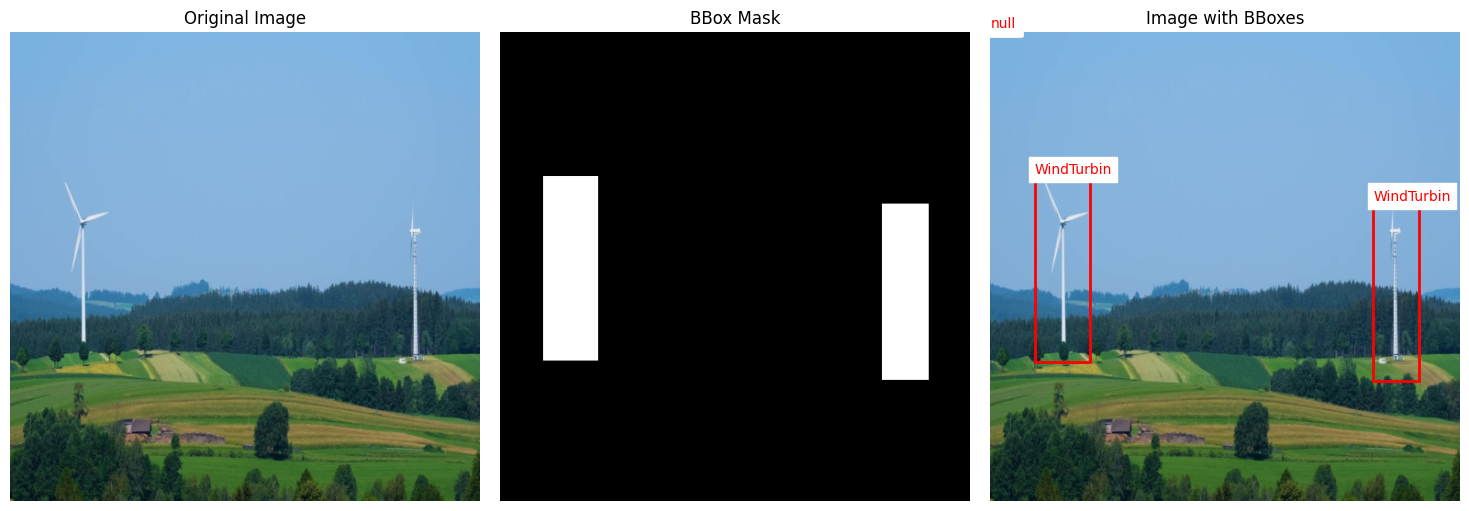

In [7]:
train_dataset = WindTurbinDataset(path + "/train/images", path + "/train/labels")
test_dataset = WindTurbinDataset(path + "/test/images", path + "/test/labels")
validation_dataset = WindTurbinDataset(path + "/valid/images", path + "/valid/labels")

print("train dataset: ", len(train_dataset))
print("test dataset: ", len(test_dataset))
print("validation dataset: ", len(validation_dataset))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
validation_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

images, boxes = next(iter(validation_loader))
item_show(images[0], boxes[0])

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [9]:
def train(model_cfg='yolov8n.yaml',
               data_cfg='tanks.yaml',
               epochs=50,
               imgsz=640,
               batch=8,
               device='cuda'):
    model = YOLO(model_cfg).to(device)

    config = {
        'data': data_cfg,
        'epochs': epochs,
        'imgsz': imgsz,
        'batch': batch,
        'device': device,
        'plots': False,
        'save_json': True,
        'exist_ok': True
    }
    results = model.train(**config)
    return model, results

def compute_mean_intersection_over_union(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    device: str = 'cuda'
) -> float:
    model.eval()
    total_iou = 0.0
    valid_samples_count = 0

    with torch.no_grad():
        for batch_inputs, batch_targets in data_loader:
            images = batch_inputs.to(device)
            batch_predictions = model(images)

            for prediction, targets in zip(batch_predictions, batch_targets):
                pred_bboxes = prediction.boxes.xyxy.cpu()
                gt_bboxes = targets[:, 1:5].cpu()

                sample_iou = _calculate_sample_iou(pred_bboxes, gt_bboxes)
                if sample_iou is not None:
                    total_iou += sample_iou
                    valid_samples_count += 1

    if valid_samples_count == 0:
        return 0.0
    return total_iou / valid_samples_count

def _calculate_sample_iou(
    predicted_bboxes: torch.Tensor,
    ground_truth_bboxes: torch.Tensor
) -> float | None:
    if len(predicted_bboxes) == 0 or len(ground_truth_bboxes) == 0:
        return None

    iou_matrix = torchvision.ops.box_iou(predicted_bboxes, ground_truth_bboxes)
    pairwise_iou = torch.diag(iou_matrix)
    return pairwise_iou.mean().item()


In [10]:
config_data = {
  "path": f"{path}/",
  "train": "train/images",
  "val": "valid/images",
  "names": {0: "WindTurbin"}
}
config_path = "dataset_config.yaml"
with open(config_path, "w") as f:
  yaml.dump(config_data, f, sort_keys=False)
  config_path = os.path.abspath(config_path)

print(config_path)

/content/dataset_config.yaml


In [11]:
model, results = train(
        model_cfg='yolov8n.yaml',
        data_cfg=str(config_path),
        epochs=EPOCHS,
        device=device
)

engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset_config.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=False, pose=12.0, pretrained=True, profile=False, project=None, rect=False, resume=False, retina_masks=False, 

100%|██████████| 755k/755k [00:00<00:00, 28.7MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

YOLOv8n summary: 129 layers, 3,011,043 parameters, 3,011,027 gradients, 8.2 GFLOPs

Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 90.0MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.1±0.1 ms, read: 38.4±7.0 MB/s, size: 211.7 KB)


train: Scanning /kaggle/input/wind-turbine-image-dataset-for-computer-vision/train/labels... 2643 images, 15 backgrounds, 2508 corrupt: 100%|██████████| 2643/2643 [00:24<00:00, 106.89it/s]

train: /kaggle/input/wind-turbine-image-dataset-for-computer-vision/train/images/windmill0_jpg.rf.0b0439c45bb2ea93b415335bb7d2296b.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train: /kaggle/input/wind-turbine-image-dataset-for-computer-vision/train/images/windmill0_jpg.rf.0d733990dec55da4927a7fdd3c7814bf.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train: /kaggle/input/wind-turbine-image-dataset-for-computer-vision/train/images/windmill0_jpg.rf.17c02820f60e65581c01d4f5d90b6e39.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train: /kaggle/input/wind-turbine-image-dataset-for-computer-vision/train/images/windmill0_jpg.rf.1cacfc9821d3c21657561cc1b0835cfc.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train: /kaggle/input/wind-turbine-im

WARNING ⚠️ train: Cache directory /kaggle/input/wind-turbine-image-dataset-for-computer-vision/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 27.8±15.2 MB/s, size: 153.7 KB)


val: Scanning /kaggle/input/wind-turbine-image-dataset-for-computer-vision/valid/labels... 247 images, 1 backgrounds, 239 corrupt: 100%|██████████| 247/247 [00:02<00:00, 114.59it/s]

val: /kaggle/input/wind-turbine-image-dataset-for-computer-vision/valid/images/windmill0_jpg.rf.2f6cdff22a93d969aa02da87f6a6ec04.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /kaggle/input/wind-turbine-image-dataset-for-computer-vision/valid/images/windmill0_jpg.rf.9888e4aa9f9e310cf4522ab23e141bc2.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /kaggle/input/wind-turbine-image-dataset-for-computer-vision/valid/images/windmill10_jpg.rf.850b1f897127e2b495bac0c4242f8319.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /kaggle/input/wind-turbine-image-dataset-for-computer-vision/valid/images/windmill11_jpg.rf.29c2fd3b94bffeb84ded56fb292a792d.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /kaggle/input/wind-turbine-image-data

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.08G      4.366      3.891      4.328         56        640: 100%|██████████| 17/17 [00:06<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.57s/it]

                   all          8         24    0.00208      0.208    0.00314   0.000887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.09G      4.106      3.574      4.175         36        640: 100%|██████████| 17/17 [00:03<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.75it/s]


                   all          8         24    0.00125      0.125    0.00326     0.0012

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.11G      3.726      3.215          4         21        640: 100%|██████████| 17/17 [00:03<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]

                   all          8         24    0.00125      0.125    0.00393    0.00117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.13G      3.501      2.973      3.848         55        640: 100%|██████████| 17/17 [00:03<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

                   all          8         24    0.00167      0.167    0.00433    0.00122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      1.15G      3.263      2.829      3.621         28        640: 100%|██████████| 17/17 [00:03<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]

                   all          8         24    0.00208      0.208    0.00467    0.00154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.16G      3.054      2.873      3.445         43        640: 100%|██████████| 17/17 [00:03<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.29it/s]

                   all          8         24    0.00208      0.208    0.00568    0.00156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      1.18G      3.012      2.751      3.284         39        640: 100%|██████████| 17/17 [00:04<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]

                   all          8         24    0.00333      0.333    0.00936    0.00265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50       1.2G      2.903      2.629      3.201         51        640: 100%|██████████| 17/17 [00:04<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]

                   all          8         24     0.0463       0.25     0.0345     0.0175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.21G       2.93      2.611      3.148         61        640: 100%|██████████| 17/17 [00:03<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.94it/s]

                   all          8         24      0.122      0.208      0.048       0.02



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.23G       2.87       2.45      3.006         86        640: 100%|██████████| 17/17 [00:04<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]

                   all          8         24     0.0313       0.25     0.0249      0.011



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.25G      2.685      2.304      2.922         40        640: 100%|██████████| 17/17 [00:03<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


                   all          8         24      0.104      0.125     0.0344     0.0106

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.27G      2.661      2.267      2.867         71        640: 100%|██████████| 17/17 [00:03<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]

                   all          8         24      0.184      0.208      0.134     0.0471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      1.28G      2.506      2.257      2.755         44        640: 100%|██████████| 17/17 [00:04<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.08it/s]

                   all          8         24      0.239      0.458      0.223      0.063



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50       1.3G      2.474      2.133      2.715         68        640: 100%|██████████| 17/17 [00:03<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


                   all          8         24      0.249      0.333      0.229     0.0966

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.32G      2.445      2.071      2.658         56        640: 100%|██████████| 17/17 [00:03<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]

                   all          8         24      0.469      0.222       0.26      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.33G      2.352      1.923      2.578         26        640: 100%|██████████| 17/17 [00:03<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.12it/s]

                   all          8         24      0.417      0.269      0.222      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      1.35G      2.291      1.963      2.549         22        640: 100%|██████████| 17/17 [00:03<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]

                   all          8         24      0.237      0.125     0.0823     0.0233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      1.37G       2.36      1.871      2.531         26        640: 100%|██████████| 17/17 [00:02<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]

                   all          8         24      0.319      0.167      0.154     0.0669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.38G      2.246      1.789      2.492         35        640: 100%|██████████| 17/17 [00:03<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]

                   all          8         24      0.272      0.333      0.213     0.0737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50       1.4G      2.248      1.793      2.504         39        640: 100%|██████████| 17/17 [00:03<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

                   all          8         24      0.642      0.292      0.279      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.42G      2.183      1.799      2.451         26        640: 100%|██████████| 17/17 [00:03<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.08it/s]


                   all          8         24      0.534      0.333      0.307      0.117

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.44G      2.141       1.71      2.413         67        640: 100%|██████████| 17/17 [00:02<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]

                   all          8         24      0.872      0.292      0.343       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      1.45G      2.097      1.603       2.39         64        640: 100%|██████████| 17/17 [00:04<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


                   all          8         24       0.47      0.333      0.229     0.0844

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      1.47G      1.981      1.557      2.327         51        640: 100%|██████████| 17/17 [00:03<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.04it/s]


                   all          8         24      0.312      0.292      0.178     0.0672

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      1.49G      1.972      1.579      2.303         44        640: 100%|██████████| 17/17 [00:03<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.68it/s]

                   all          8         24      0.584      0.292       0.27     0.0769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50       1.5G       1.98      1.495      2.244         38        640: 100%|██████████| 17/17 [00:04<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.88it/s]


                   all          8         24       0.41       0.25      0.238     0.0707

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      1.52G      1.965      1.535      2.249         59        640: 100%|██████████| 17/17 [00:03<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.17it/s]


                   all          8         24      0.312      0.333      0.241     0.0925

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      1.54G      1.913      1.451       2.19         45        640: 100%|██████████| 17/17 [00:03<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]

                   all          8         24      0.487      0.167      0.156     0.0604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      1.55G      1.897      1.487      2.226         26        640: 100%|██████████| 17/17 [00:04<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]

                   all          8         24       0.24      0.292      0.135     0.0541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      1.57G      1.865      1.466      2.129         46        640: 100%|██████████| 17/17 [00:03<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]

                   all          8         24      0.556      0.262      0.211     0.0807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      1.59G      1.854      1.482      2.199         64        640: 100%|██████████| 17/17 [00:03<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]

                   all          8         24      0.396      0.208      0.233     0.0996



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      1.61G      1.872      1.467      2.133         35        640: 100%|██████████| 17/17 [00:04<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]

                   all          8         24      0.451       0.25      0.239       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      1.62G      1.747      1.355      2.054         41        640: 100%|██████████| 17/17 [00:03<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]

                   all          8         24      0.708      0.333      0.394      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      1.64G      1.774      1.319      2.063         78        640: 100%|██████████| 17/17 [00:03<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.44it/s]


                   all          8         24      0.601      0.458      0.403      0.149

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      1.66G      1.676      1.258       1.97         38        640: 100%|██████████| 17/17 [00:04<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]

                   all          8         24      0.403       0.45      0.379      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      1.68G      1.735      1.329      2.025         20        640: 100%|██████████| 17/17 [00:03<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]

                   all          8         24      0.348        0.4       0.29     0.0974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      1.69G      1.674      1.295       2.01         44        640: 100%|██████████| 17/17 [00:03<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]

                   all          8         24      0.387      0.264      0.261      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      1.71G      1.668      1.243      1.961         66        640: 100%|██████████| 17/17 [00:03<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]

                   all          8         24      0.467      0.375      0.376      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      1.73G      1.697      1.326      1.959         54        640: 100%|██████████| 17/17 [00:03<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]

                   all          8         24      0.377      0.417      0.318      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      1.74G      1.692      1.325      2.024         48        640: 100%|██████████| 17/17 [00:03<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.76it/s]


                   all          8         24      0.314        0.5      0.332      0.156
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      1.76G      1.528      1.381      1.899         19        640: 100%|██████████| 17/17 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]

                   all          8         24      0.459      0.542      0.439      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      1.78G      1.473      1.289      1.829         10        640: 100%|██████████| 17/17 [00:02<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]

                   all          8         24      0.727      0.375       0.41      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50       1.8G      1.548      1.392      1.875         21        640: 100%|██████████| 17/17 [00:02<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

                   all          8         24      0.526       0.37      0.368      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      1.81G      1.488      1.345      1.822         32        640: 100%|██████████| 17/17 [00:03<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.47it/s]

                   all          8         24      0.552      0.333      0.415      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      1.83G      1.479      1.226      1.798         12        640: 100%|██████████| 17/17 [00:03<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]

                   all          8         24      0.591      0.333      0.418      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      1.85G      1.491      1.244      1.836         26        640: 100%|██████████| 17/17 [00:03<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.64it/s]

                   all          8         24      0.604        0.5       0.49      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      1.87G      1.441      1.164      1.754         25        640: 100%|██████████| 17/17 [00:02<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

                   all          8         24       0.64      0.519      0.521      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      1.88G      1.444      1.203      1.796         16        640: 100%|██████████| 17/17 [00:04<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.94it/s]

                   all          8         24      0.672      0.426      0.518      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50       1.9G      1.492      1.222       1.82         33        640: 100%|██████████| 17/17 [00:02<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]

                   all          8         24      0.657      0.458      0.504      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      1.91G      1.373      1.118      1.763         24        640: 100%|██████████| 17/17 [00:02<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.93it/s]

                   all          8         24      0.646      0.458      0.504      0.172



50 epochs completed in 0.059 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.42it/s]

                   all          8         24      0.637      0.511      0.521      0.194
Speed: 1.4ms preprocess, 2.8ms inference, 0.0ms loss, 1.3ms postprocess per image
Saving runs/detect/train/predictions.json...
Results saved to runs/detect/train


In [12]:
print("precision", results.results_dict['metrics/precision(B)'])
print("recall", results.results_dict['metrics/recall(B)'])
print("mAP50", results.results_dict['metrics/mAP50(B)'])
print("mAP50-95", results.results_dict['metrics/mAP50-95(B)'])

precision 0.6366089201329476
recall 0.5113773193483339
mAP50 0.5209689105410606
mAP50-95 0.19384053651952596
